In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'numpy'

# Preprocess from Previous Seminars

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns):
        self.woe_columns = woe_columns # Columns Which Should Be Preprocessed Using WOE
        self.one_hot_columns = one_hot_columns # Columns Which Should Be Preprocessed Using One Hot Encoder

    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values

        return self


    def transform(self, X):
        X_transformed = X.copy()

        # Preprocess WOE Columns
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)

        n = X_transformed.isna().mean()

        na_cols = list(n[n > 0].index)

        for col in na_cols:
            name, pr = col.split("_")
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])
            
        return X_transformed

In [ ]:
df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_ids = X_train.pop('id')
test_ids = X_test.pop('id')

cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

s = X_train[cat_cols].nunique()

threshold = 3

woe_columns = list(s[s > 3].index)
one_hot_columns = list(s[s <= 3].index)

Categorical columns (19): ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
Numerical columns (11): ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']


In [ ]:
preprocessor = CustomPreprocessor(woe_columns=woe_columns, one_hot_columns=one_hot_columns)

In [ ]:
X_train_t = preprocessor.fit_transform(X_train, y_train)

In [ ]:
X_train_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 254099 to 121958
Data columns (total 35 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cont0      240000 non-null  float64
 1   cont1      240000 non-null  float64
 2   cont2      240000 non-null  float64
 3   cont3      240000 non-null  float64
 4   cont4      240000 non-null  float64
 5   cont5      240000 non-null  float64
 6   cont6      240000 non-null  float64
 7   cont7      240000 non-null  float64
 8   cont8      240000 non-null  float64
 9   cont9      240000 non-null  float64
 10  cont10     240000 non-null  float64
 11  cat1_woe   240000 non-null  float64
 12  cat2_woe   240000 non-null  float64
 13  cat3_woe   240000 non-null  float64
 14  cat4_woe   240000 non-null  float64
 15  cat5_woe   240000 non-null  float64
 16  cat6_woe   240000 non-null  float64
 17  cat7_woe   240000 non-null  float64
 18  cat8_woe   240000 non-null  float64
 19  cat9_woe   240000 non-n

In [ ]:
X_train.shape, X_train_t.shape

((240000, 30), (240000, 35))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [ ]:
X = X_train_t
y = y_train

# 1. Linear Models: Logistic Regression

## Without Standardization

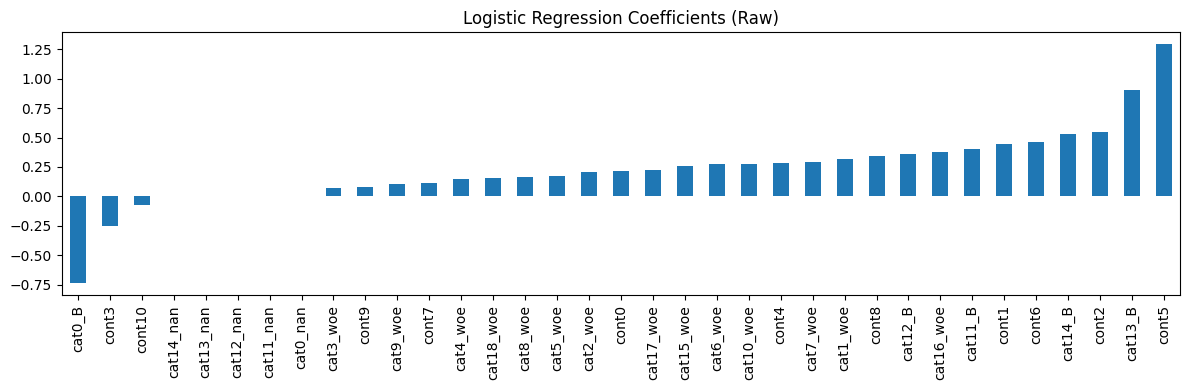

In [ ]:
lr_raw = LogisticRegression(max_iter=1000)
lr_raw.fit(X, y)
coeff_raw = pd.Series(lr_raw.coef_[0], index=X.columns)
coeff_raw.sort_values().plot(kind="bar", figsize=(12, 4), title="Logistic Regression Coefficients (Raw)")
plt.tight_layout()
plt.show()

## With Standardization

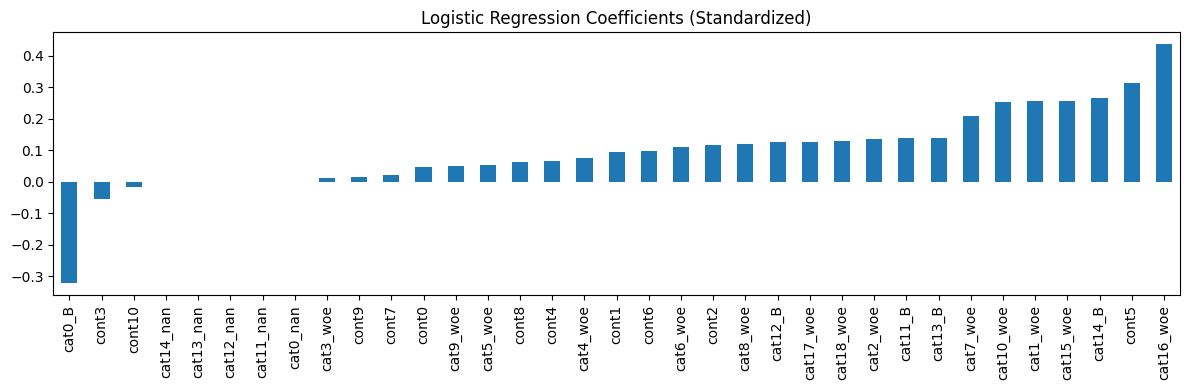

CPU times: user 1.24 s, sys: 23 ms, total: 1.26 s
Wall time: 956 ms


In [ ]:
%%time

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr_scaled = LogisticRegression(max_iter=1000)
lr_scaled.fit(X_scaled, y)
coeff_scaled = pd.Series(lr_scaled.coef_[0], index=X.columns)
coeff_scaled.sort_values().plot(kind="bar", figsize=(12, 4), title="Logistic Regression Coefficients (Standardized)")
plt.tight_layout()
plt.show()

# 2. Permutation Importance (Model-agnostic)

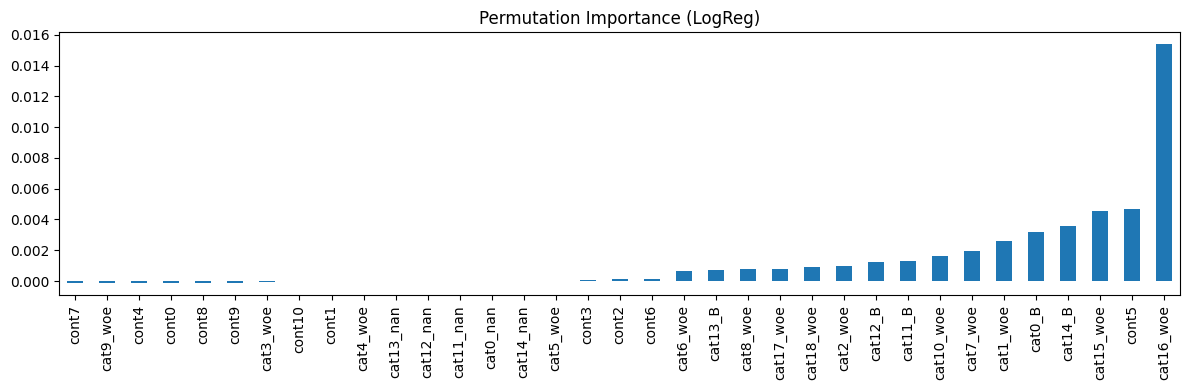

CPU times: user 25.7 s, sys: 4.25 s, total: 30 s
Wall time: 26.1 s


In [ ]:
%%time

perm_model = LogisticRegression(max_iter=1000)
perm_model.fit(X, y)
perm_result = permutation_importance(perm_model, X, y, n_repeats=10, random_state=42)
pd.Series(perm_result.importances_mean, index=X.columns).sort_values().plot(kind="bar", figsize=(12, 4), title="Permutation Importance (LogReg)")
plt.tight_layout()
plt.show()

# 3. Decision Tree Feature Importances

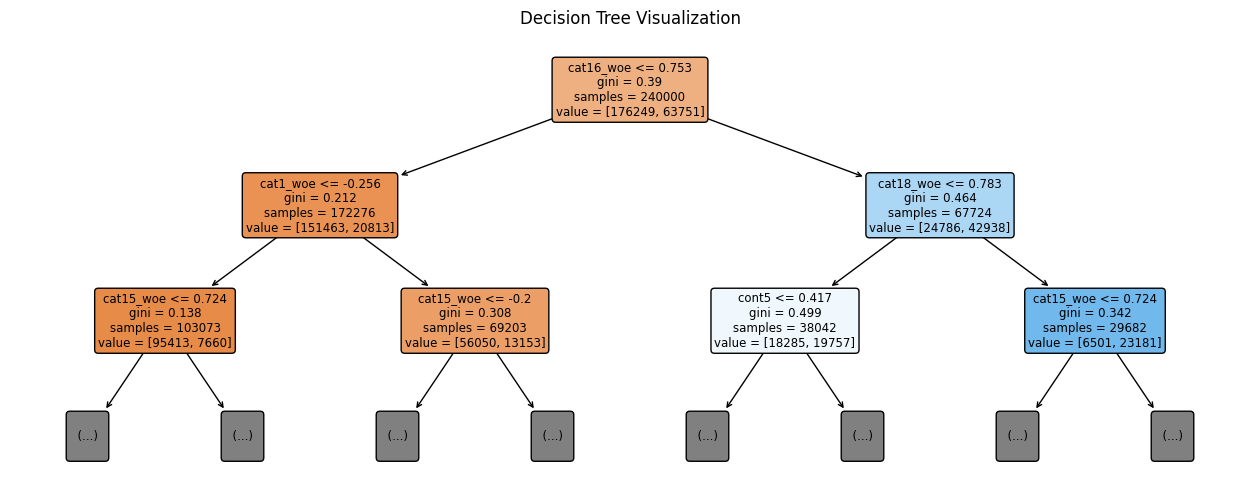

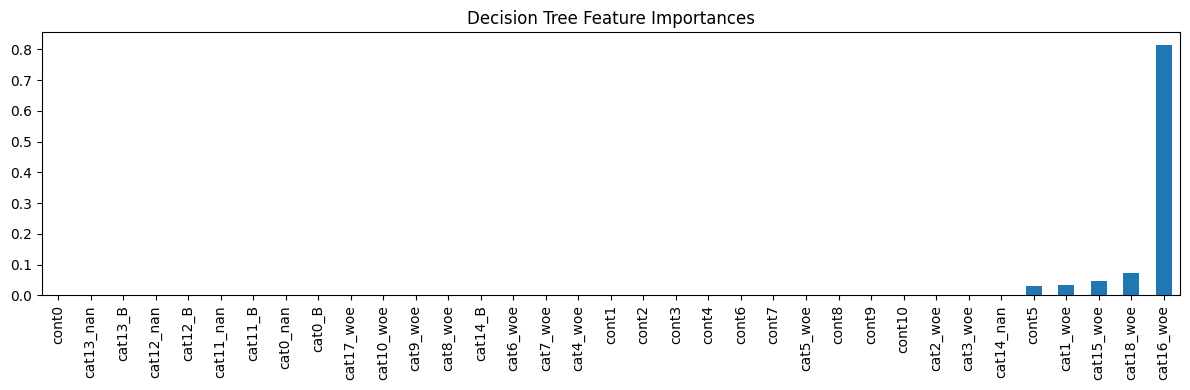

CPU times: user 2.66 s, sys: 29.1 ms, total: 2.69 s
Wall time: 2.69 s


In [ ]:
%%time

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)
plt.figure(figsize=(16, 6))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, max_depth=2)
plt.title("Decision Tree Visualization")
plt.show()

pd.Series(tree.feature_importances_, index=X.columns).sort_values().plot(kind="bar", figsize=(12, 4), title="Decision Tree Feature Importances")
plt.tight_layout()
plt.show()


# 4. Random Forest

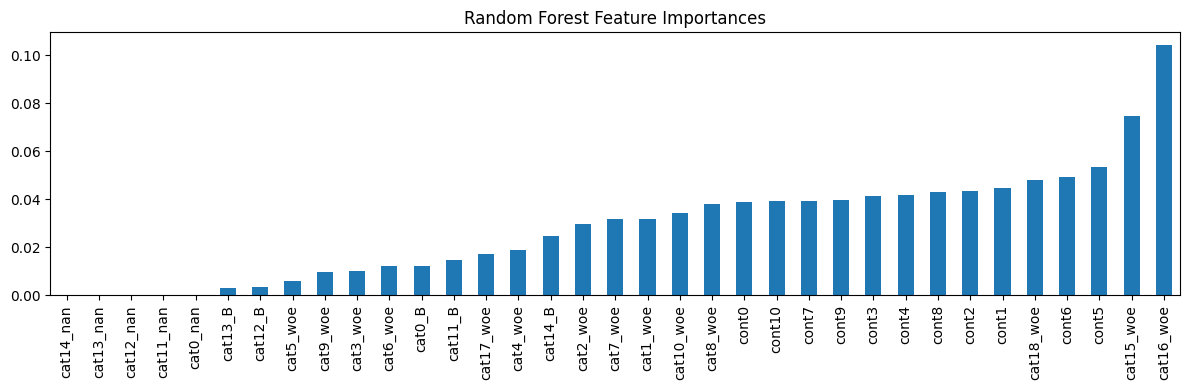

CPU times: user 1min 40s, sys: 256 ms, total: 1min 40s
Wall time: 1min 40s


In [ ]:
%%time

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind="bar", figsize=(12, 4), title="Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# 5. Boosted Trees (XGBoost)

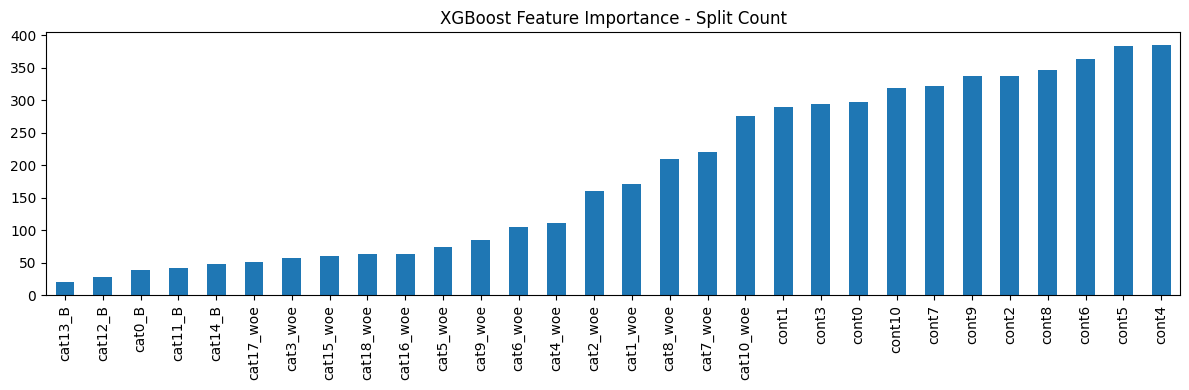

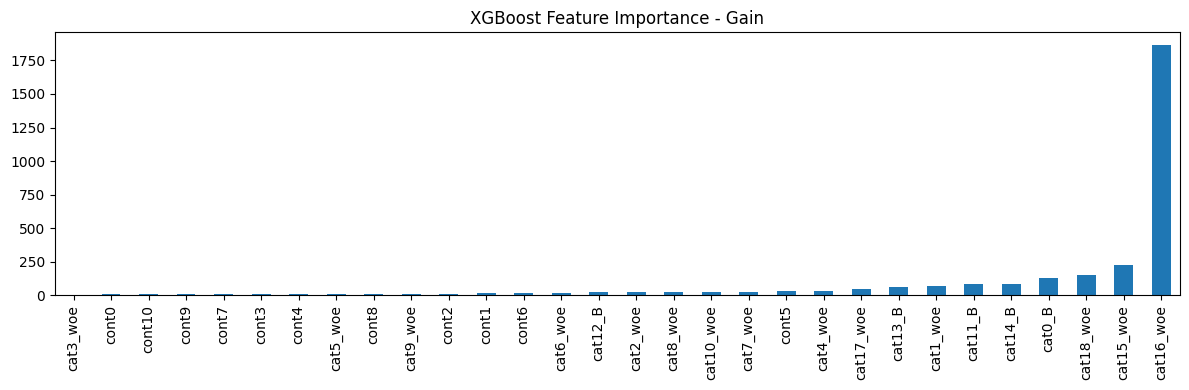

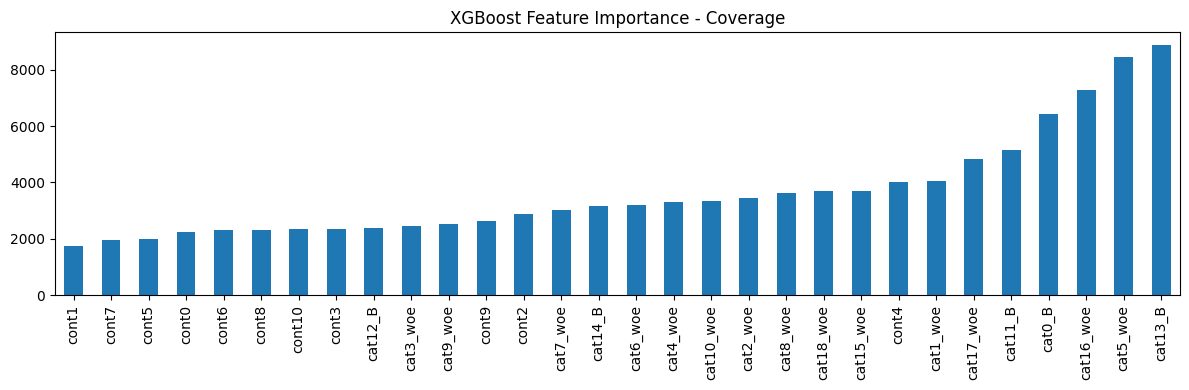

CPU times: user 9.21 s, sys: 81.6 ms, total: 9.29 s
Wall time: 3.46 s


In [ ]:
%%time

xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X, y)

# Split count
xgb_scores_split = xgb.get_booster().get_score(importance_type='weight')

# Info gain
xgb_scores_gain = xgb.get_booster().get_score(importance_type='gain')

# Coverage
xgb_scores_cover = xgb.get_booster().get_score(importance_type='cover')

# Convert to series and plot
for name, scores in zip(['Split Count', 'Gain', 'Coverage'], [xgb_scores_split, xgb_scores_gain, xgb_scores_cover]):
    s = pd.Series(scores).sort_values()
    s.plot(kind="bar", figsize=(12, 4), title=f"XGBoost Feature Importance - {name}")
    plt.tight_layout()
    plt.show()

# Submit Submission.csv

In [ ]:
# /kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
# /kaggle/input/tabular-playground-series-mar-2021/train.csv
# /kaggle/input/tabular-playground-series-mar-2021/test.csv

test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

In [ ]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,B,L,C,A,F,BI,A,E,AX,...,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,A,F,A,B,F,BI,A,AH,I,...,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


In [ ]:
submission_ids = test.pop('id')

test_t = preprocessor.transform(test)

In [ ]:
X_test_t = preprocessor.transform(X_test)

In [ ]:
test_t.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat0_B,cat0_nan,cat11_B,cat11_nan,cat12_B,cat12_nan,cat13_B,cat13_nan,cat14_B,cat14_nan
0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,...,0,0,0,0,0,0,0,0,0,0
1,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,...,0,0,0,0,0,0,0,0,1,0
2,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,...,0,0,0,0,0,0,0,0,1,0
3,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,...,1,0,0,0,0,0,0,0,0,0
4,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,...,0,0,0,0,0,0,0,0,0,0


## Evaluate AUC on Test

In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = xgb.predict_proba(X_test_t)[:, 1]  # get probability for class 1
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC on X_test_t: {auc_score:.4f}")

AUC on X_test_t: 0.8909


## Create and Save Submission File

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv')

In [ ]:
sample_submission.head()

,id,target
0,5,0.5
1,6,0.5
2,8,0.5
3,9,0.5
4,11,0.5


In [ ]:
test_proba = xgb.predict_proba(test_t)[:, 1]

# 3. Create and save the submission file
submission = pd.DataFrame({
    "id": submission_ids,  # or test_t["Id"] if you have an Id column
    "target": test_proba
})
submission.to_csv("/kaggle/working/submission.csv", index=False)

# SHAP Values

In [ ]:
import shap

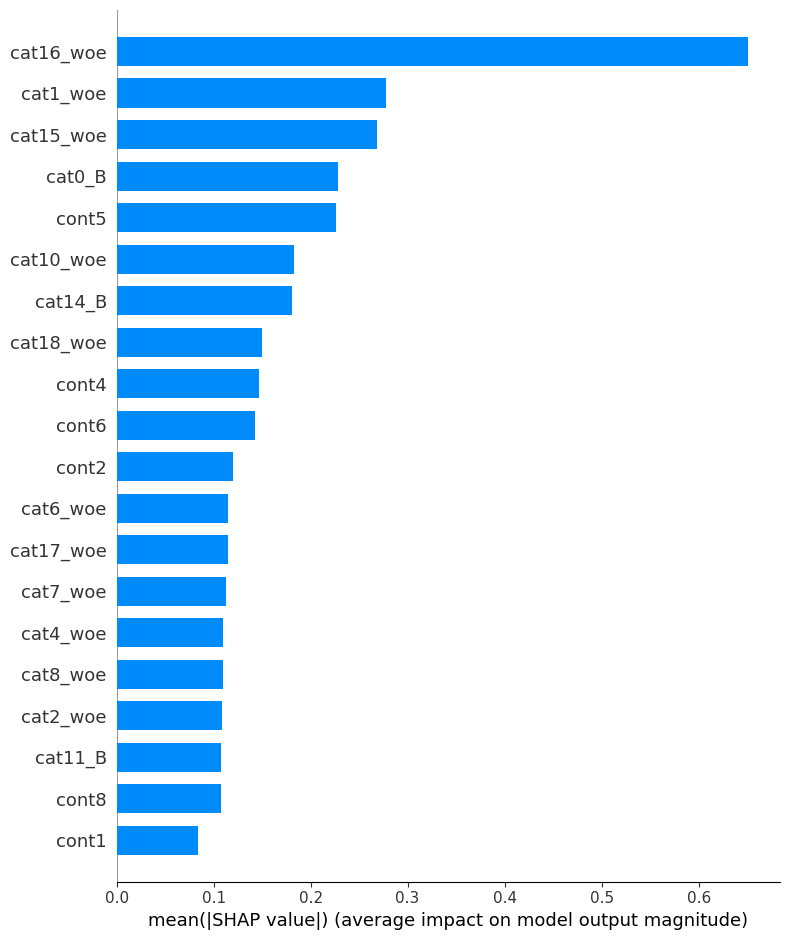

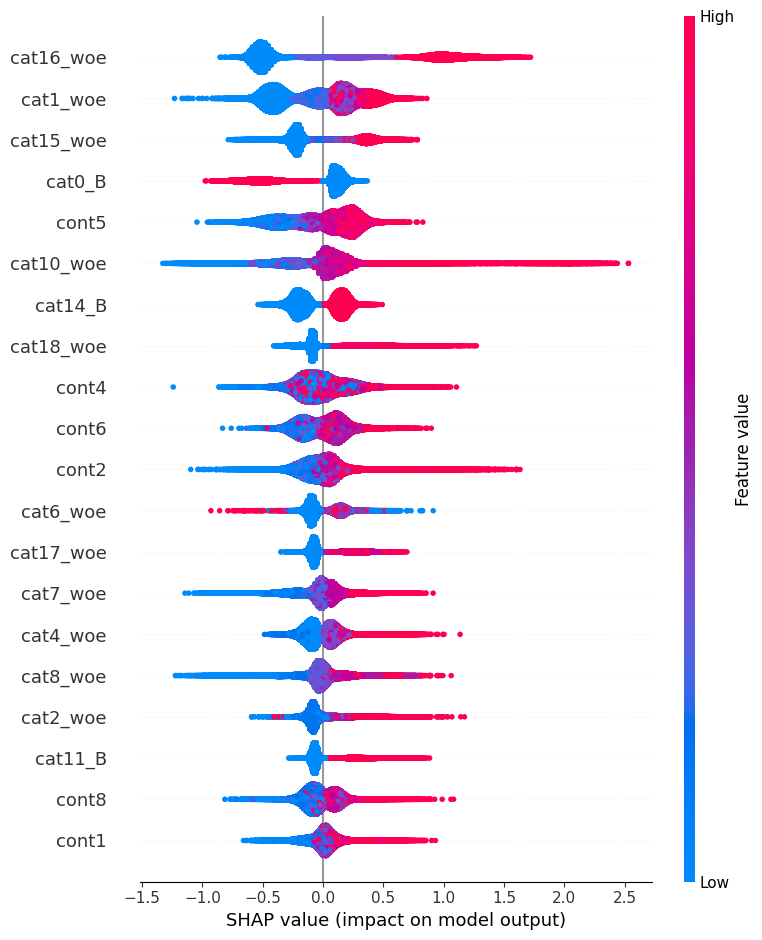

CPU times: user 7min 14s, sys: 364 ms, total: 7min 14s
Wall time: 3min 55s


In [ ]:
%%time

explainer = shap.Explainer(xgb)
shap_values = explainer(X)

# Summary plot (global importance)
shap.summary_plot(shap_values, X, plot_type="bar")

# Summary plot (beeswarm - distribution of SHAP values per feature)
shap.summary_plot(shap_values, X)

# Force plot for a single prediction (optional)
shap.plots.force(shap_values[0])